In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import scipy.signal
from scipy.signal import windows
scipy.signal.gaussian = windows.gaussian

import jax
import time
import json
import json
import torch
import pickle
import pprint
import pathlib
import textwrap
import numpy as np
import arviz as az
import pandas as pd
import seaborn as sns 
import multiprocessing as mp
import sbi.utils as sbi_utils
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy import stats
from pathlib import Path
from sbi import utils as sbi_utils
from mf_npe.pipeline import Pipeline
from sbi.inference import simulate_for_sbi, SNPE
from multiprocessing import Pool, cpu_count
from mf_npe.config.TaskSetup import TaskSetup
from mf_npe.diagnostics.ppc import summarize_voltage 
from mf_npe.simulator.high_fidelity_hh import MarkovHHSimulator   # High fidelity simulator
from mf_npe.simulator.low_fidelity_hh import NoisyHHSimulator     # Low fidelity simulator
from sbi.utils.simulation_utils import simulate_for_sbi
from mf_npe.utils.utils import summarize_voltage, set_global_seed

/var/autofs/misc/home/petera/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


→ Loading pre‐trained MF‐NPE4 (H1000) posterior from disk
→ Loading pre‐trained MF‐NPE5 (H1000) posterior from disk
→ Loading pre‐trained HF‐only NPE (H1000) posterior from disk
Using x_obs_mf.shape = torch.Size([1, 8])
HF expects x of shape torch.Size([4])
Using x_obs_hf.shape = torch.Size([1, 4])


/tmp/ipykernel_3539116/2472040323.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(path)
                        constant for `log_prob()`. However, on

NLTP  MF-NPE4 (H1000) = 9.039 nats
NLTP  MF-NPE5 (H1000) = 8.242 nats
NLTP  NPE-HF  (H1000) = 10.133 nats


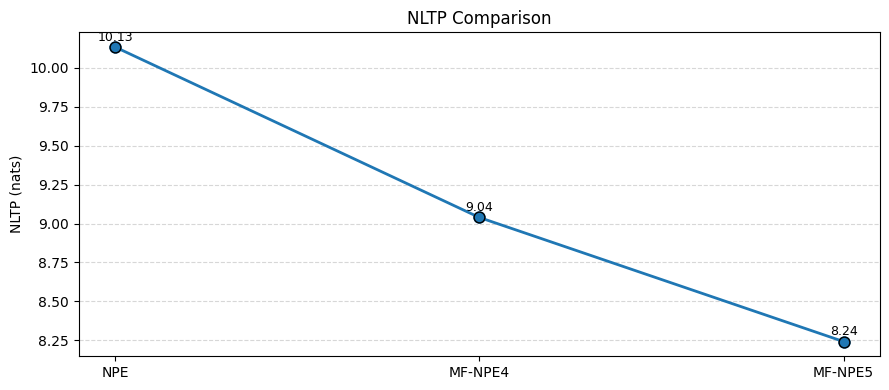

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pathlib
import pickle
from sbi import utils as sbi_utils

# ─────────────────────────────────────────────────────────────────────────────
# GLOBAL SEED‐SETTING
# ─────────────────────────────────────────────────────────────────────────────
def set_global_seed(s: int):
    np.random.seed(s)
    torch.manual_seed(s)

# ─────────────────────────────────────────────────────────────────────────────
# CONSTANTS & REPRODUCIBILITY
# ─────────────────────────────────────────────────────────────────────────────
ROOT = pathlib.Path("")
ROOT.mkdir(parents=True, exist_ok=True)

OBS_PATH     = pathlib.Path("outputs/single_hf_trace/markov_ground_truth_trace.npz")

# Paths to the six pre‐trained posteriors:
#Mf4_POST_PATH = ROOT / "mf_npe_4_100/mf_de_4_100.pkl"
#Mf5_POST_PATH = ROOT / "mf_npe_5_100/mf_de.pkl"
MF4_POST_PATH = ROOT / "outputs/mf_npe_4_1000/posteriors/mf_de_4_1000.pkl"
MF5_POST_PATH = ROOT / "outputs/mf_npe_5_1000/posteriors/mf_de.pkl"
HF_POST_PATH  = ROOT / "outputs/npe_1000/posteriors/npe_de_1000.pkl"

N_WORKERS = 19
SEED_DATA = 2025

torch.set_default_dtype(torch.float32)
set_global_seed(SEED_DATA)

# ─────────────────────────────────────────────────────────────────────────────
# LOAD HF OBSERVATION
# ─────────────────────────────────────────────────────────────────────────────
obs_npz = np.load(OBS_PATH)
t_vec = obs_npz["t"]
V_obs = obs_npz["Vhi"]
theta_true_np = obs_npz["theta"]
x_obs_np = obs_npz["summary"]  

# Convert to torch
theta_true = torch.as_tensor(theta_true_np, dtype=torch.float32) 
theta_true_b = theta_true.unsqueeze(0)  

x_obs = torch.as_tensor(x_obs_np, dtype=torch.float32)
x_obs_hf = x_obs.unsqueeze(0) if x_obs.ndim == 1 else x_obs 

# ─────────────────────────────────────────────────────────────────────────────
# PRIOR OVER PARAMETERS (only used for NLTP evaluation)
# ─────────────────────────────────────────────────────────────────────────────
prior = sbi_utils.BoxUniform(
    low  = torch.tensor([50.0, 20.0, 0.1]),
    high = torch.tensor([200.0, 100.0, 1.0]))

# ─────────────────────────────────────────────────────────────────────────────
# HELPER TO LOAD A POSTERIOR
# ─────────────────────────────────────────────────────────────────────────────
def load_posterior(path: pathlib.Path):
    """
    Attempt to load a posterior via torch.load; if that fails, fall back to pickle.load.
    """
    try:
        return torch.load(path)
    except Exception:
        with open(path, "rb") as f:
            return pickle.load(f)

# ─────────────────────────────────────────────────────────────────────────────
# LOAD ALL POSTERIORS
# ─────────────────────────────────────────────────────────────────────────────
#print("→ Loading pre‐trained MF‐NPE4 posterior from disk")
#mf41_posterior = load_posterior(Mf4_POST_PATH)

#print("→ Loading pre‐trained MF‐NPE5 posterior from disk")
#mf51_posterior = load_posterior(Mf5_POST_PATH)

print("→ Loading pre‐trained MF‐NPE4 (H1000) posterior from disk")
mf4_posterior = load_posterior(MF4_POST_PATH)

print("→ Loading pre‐trained MF‐NPE5 (H1000) posterior from disk")
mf5_posterior = load_posterior(MF5_POST_PATH)

print("→ Loading pre‐trained HF‐only NPE (H1000) posterior from disk")
hf_posterior  = load_posterior(HF_POST_PATH)

# ─────────────────────────────────────────────────────────────────────────────
# LOW-FIDELITY SUMMARY FOR MF-NPE
# ─────────────────────────────────────────────────────────────────────────────
# ----- Replace these with your real functions -----
def simulate_lf(theta_np):
    return np.ones(500) * np.sum(theta_np)  

def summarize_voltage_lf(V_lf):
    return np.array([np.mean(V_lf), np.std(V_lf), np.max(V_lf), np.min(V_lf)])

V_lf = simulate_lf(theta_true_np)
x_obs_lf_np = summarize_voltage_lf(V_lf)
x_obs_lf = torch.as_tensor(x_obs_lf_np, dtype=torch.float32).unsqueeze(0)  

x_obs_mf = torch.cat([x_obs_lf, x_obs_hf], dim=1)  

# ─────────────────────────────────────────────────────────────────────────────
# CHECK SHAPES (DEBUG)
# ─────────────────────────────────────────────────────────────────────────────
#print("MF-NPE4_100 expects x of shape", mf41_posterior.posterior_estimator.condition_shape)
print("Using x_obs_mf.shape =", x_obs_mf.shape)
print("HF expects x of shape", hf_posterior.posterior_estimator.condition_shape)
print("Using x_obs_hf.shape =", x_obs_hf.shape)

# ─────────────────────────────────────────────────────────────────────────────
# COMPUTE NLTP FOR θ_true UNDER EACH POSTERIOR
# ─────────────────────────────────────────────────────────────────────────────
#nltp_mf41 = -mf41_posterior.log_prob(theta_true_b, x=x_obs_mf).item()
#nltp_mf51 = -mf51_posterior.log_prob(theta_true_b, x=x_obs_mf).item()
nltp_mf4  = -mf4_posterior.log_prob(theta_true_b, x=x_obs_mf).item()
nltp_mf5  = -mf5_posterior.log_prob(theta_true_b, x=x_obs_mf).item()
nltp_hf   = -hf_posterior.log_prob(theta_true_b, x=x_obs_hf).item()

#print(f"NLTP  MF-NPE4 (H100)  = {nltp_mf41:.3f} nats")
#print(f"NLTP  MF-NPE5 (H100)  = {nltp_mf51:.3f} nats")
print(f"NLTP  MF-NPE4 (H1000) = {nltp_mf4:.3f} nats")
print(f"NLTP  MF-NPE5 (H1000) = {nltp_mf5:.3f} nats")
print(f"NLTP  NPE-HF  (H1000) = {nltp_hf:.3f} nats")

# ─────────────────────────────────────────────────────────────────────────────
# LINE+MARKER PLOT OF NLTP VALUES
# ─────────────────────────────────────────────────────────────────────────────
methods    = [ 'NPE', 'MF-NPE4', 'MF-NPE5']
nltp_vals  = [ nltp_hf, nltp_mf4, nltp_mf5]
x_positions = np.arange(len(methods))

plt.figure(figsize=(9, 4))

# Plot a connected line with markers at each NLTP
plt.plot(
    x_positions,
    nltp_vals,
    linestyle='-',
    marker='o',
    markersize=8,
    linewidth=2,
    color='C0',
    label='NLTP'
)

# Fill circles in a darker shade
for xi, yi in zip(x_positions, nltp_vals):
    plt.scatter(
        xi, yi,
        color='C0',
        s=60,
        edgecolor='black',
        zorder=3
    )

# Annotate each point with its NLTP value
for xi, yi in zip(x_positions, nltp_vals):
    plt.text(
        xi, yi + 0.02,  # slight vertical offset
        f"{yi:.2f}",
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.xticks(x_positions, methods)
plt.ylabel("NLTP (nats)")
plt.title("NLTP Comparison")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

# ─────────────────────────────────────────────────────────────────────────────
# 11. SAVE AND SHOW PLOT
# ─────────────────────────────────────────────────────────────────────────────
line_png = ROOT / "nltp_comparison.png"
line_pdf = ROOT / "nltp_comparison.pdf"
plt.savefig(line_png, dpi=150)
plt.savefig(line_pdf)
plt.show()
